In [1]:
################################################################################
# MIT License
#
# Copyright (c) 2021 University of Amsterdam
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to conditions.
#
# Author: Deep Learning Course (UvA) | Fall 2022 & Oliver Gurney-Champion | Spring 2023
# Date modified: Jan 2023
################################################################################


# Import requiered packages
imports the packages and sets the random seed

In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
import random
import numpy as np
import helper_functions as hf
import torch
from matplotlib import pyplot as plt

# set random seed
seed =42

login to your free wandb account. Note you will need to set up your account on https://wandb.ai/authorize
wandb allows you to keep track of your neural network training.

In [3]:
import wandb
wandb.login()

wandb: Currently logged in as: j-l-leeb (j-l-leeb-vrije-universiteit-amsterdam) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

# Simulate and view the IVIM data
Here, we split our data into a training set, validation set and test set. Note that the current implementation only uses the training set and it is up to you (in your exercises) to also implement the validation and test run. At this point, we already split the data for you.

In [4]:
# set b-values at which we "measure" (i.e. simulate signal)
bvalues=[0, 10, 20, 30, 50, 75, 100, 150, 300, 500, 700, 1000]

## Set the random seeds for reproducibility
np.random.seed(seed)
random.seed(seed)

#determine
batch_size = 128

with wandb.init(project="AI_for_medical_imaging", job_type="visualize data") as run:
    data_sim = hf.sim_signal(SNR=(10,40),bvalues=bvalues,sims=10000,seed=np.random.randint(1,10000))
    # Only for visualisation purposes: here we create our "Artifact" in wandb --> this allows viewing the data in your wandb account
    for i in range(4):
        #make b-value data pairs
        example_data=[[x,y] for (x,y) in zip(bvalues,data_sim[0][i])]
        # put it in a table
        table = wandb.Table(data=example_data, columns=["b-values", "signal"])
        #tell wandb to plot the table
        wandb.log({"data_plot " + str(i): wandb.plot.scatter(table, "b-values", "signal")})

    # here we split the data into train (70%), test (15%) and validation (15%) sets
    #split = int(np.floor(len(data_sim[0]) * 0.7))
    train_set, test_set, val_set = torch.utils.data.random_split([[data_sim[0][i,:],data_sim[1][i],data_sim[2][i],data_sim[3][i]] for i in range(len(data_sim[3]))],[0.7,0.15,0.15])
    #split = int(np.floor(len(rest) * 0.5))
    #test_set, val_set = torch.utils.data.random_split([[rest[0][i,:],rest[1][i],rest[2][i],rest[3][i]] for i in range(len(rest[3]))],[split, len(rest[0]) - split])

    # train loader loads the trianing data. We want to shuffle to make sure data order is modified each epoch and different data is selected each epoch.
    trainloader = torch.utils.data.DataLoader(train_set,
                                   batch_size=batch_size,
                                   shuffle=True,
                                   drop_last=True)
    # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
    inferloader = torch.utils.data.DataLoader(val_set,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=True)
        # validation data is loaded here. By not shuffling, we make sure the same data is loaded for validation every time. We can use substantially more data per batch as we are not training.
    testloader = torch.utils.data.DataLoader(test_set,
                                   batch_size=batch_size,
                                   shuffle=False,
                                   drop_last=True)

wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


3 A.	Program the different neural network modules (Lineairemodule, Relumodule, Tanhmodule, MSE) in “modules.py”. Use “do_unittest.py” to test whether the forward and backward passes are correct. Make only use of matrix multiplications, no for loops. Points will be deduced when for-loops are used where matrix multiplications were possible.
3 B.  Combine all modules into a multilayer perceptron (MLP) in “exercise_3.ipynb”. Use ReLU activation functions after each fully connected linear module, except for the last module, after which a Tanh module should be used (constraining parameters between [-1, 1]). The number of layers and number of nodes per layer should be adjustable


In [5]:
"""
This module implements a multi-layer perceptron (MLP) in NumPy.
You should fill in code into indicated sections.
"""
from modules import MLP #you need to adapt these
from modules import MSE
# Both A and B done in modules.py

# Exercise 3C-D
C.	Train the neural network using just python and numpy code. You can find modules in "modules.py" which you will first have to fill in and train. You can then use these modules here!

You can use "do_unittest.py" to test whether the modules from "modules.py" have been implemented correctly.

You will need to add the updating of the gradients. As a sanity check, a network with 2 layers (64, 32), combined with a lr of 0.001, 30 epochs, and a batch size of 128 should work reasonably well and result in a systematic error of around 0.2% and a random error of around 20%.

D.	It now uses the mini-batch stochastic gradient descent algorithm. Add momentum to the training update of the weights.


In [ ]:
# define parameters
hidden_layers=(64,32)
model=MLP(len(bvalues), hidden_layers, 1)
epochs = 30
learning_rate = 0.001

# initialize wandb
wandb.init(
        project="AI_for_medical_imaging", job_type="training")

loss_module1 = MSE()


################
momentum = 0.9

# Additional code for visualization purposes
plot_data = {
    "train_loss": [],
    "val_loss": [],
    "SD_train": [],
    "SD_val": [],
    "sys_train": [],
    "sys_val": [],
}
################

# set random seed for reproducibility
torch.manual_seed(seed)

# probe available devices
if torch.cuda.is_available():  # GPU operation have separate seed
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.determinstic = True
    torch.backends.cudnn.benchmark = False

# loop over epochs
for epoch in range(epochs):
    # initiate losses to 0
    train_loss_f = 0
    val_loss_f = 0

    #####################
    # Additional code to initialize error metrics at the start of the loop
    SD_val = 0
    sys_val = 0
    SD_train = 0
    sys_train = 0
    #####################

    #loop over all training data
    for x in trainloader:
        # get data (x[0]) and put the data on the GPU if available
        batch=x[0].numpy()
        # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
        f_ref = np.expand_dims(x[2].numpy(),axis=1)
        # put the data through the neural network
        f_pred = model.forward(batch)
        # calculate loss (compare predicted f to the ground trueth)
        train_loss_f += np.mean(loss_module1.forward(f_pred, f_ref))
        # propogate the loss through the network (calculate d_wights/d_loss)
        model.backward(loss_module1.backward())

        #######################
        # PUT YOUR CODE HERE  #
        #######################

        for LM in model.LM:
            LM.last_change['weight'] = momentum * LM.last_change['weight'] + learning_rate * LM.grads['weight']
            LM.last_change['bias'] = momentum * LM.last_change['bias'] + learning_rate * LM.grads['bias']

            LM.weights -= LM.last_change['weight']
            LM.bias -= LM.last_change['bias']

        SD = np.std(f_pred - f_ref)/np.mean(f_ref)
        sys = np.mean(f_pred - f_ref)/np.mean(f_ref)
        
        SD_train += SD**2
        sys_train += sys
      
        model.clear_cache()

    # loop over all validation data
    for x in inferloader:
        # get data (x[0]) and put the data on the GPU if available
        batch=x[0].numpy()
        # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
        f_ref = np.expand_dims(x[2].numpy(),axis=1)
        # put the data through the neural network
        f_pred = model.forward(batch)
        # calculate loss (compare predicted f to the ground trueth)
        val_loss_f += np.mean(loss_module1.forward(f_pred, f_ref))

        SD = np.std(f_pred - f_ref)/np.mean(f_ref)
        sys = np.mean(f_pred - f_ref)/np.mean(f_ref)

        SD_val += SD**2
        sys_val += sys

    SD_train = np.sqrt(SD_train/trainloader.__len__())
    sys_train = sys_train/inferloader.__len__()

    SD_val = np.sqrt(SD_val/inferloader.__len__())
    sys_val = sys_val/inferloader.__len__()

    plot_data["train_loss"].append(train_loss_f/trainloader.__len__())
    plot_data["val_loss"].append(val_loss_f/inferloader.__len__())
    plot_data["SD_train"].append(SD_train)
    plot_data["SD_val"].append(SD_val)  
    plot_data["sys_train"].append(sys_train)
    plot_data["sys_val"].append(sys_val)
    
    #######################
    # END OF YOUR CODE    #
    #######################

    # initialize error_metrics
    # SD_val=0
    # sys_val=0
    wandb.log({"loss/train": train_loss_f/trainloader.__len__(),"loss/val": val_loss_f/inferloader.__len__(),"error/random error":SD_val,"error/systematic error":sys_val})
    print('epoch = ' + str(epoch) + 
          ' train loss = ' + str(round(train_loss_f/trainloader.__len__(), 3)) + 
          ' val loss = ' + str(round(val_loss_f/inferloader.__len__(), 3)) + 
          ' the systematic error is ' + str(round(sys_val * 100, 3)) + '%' + 
          ' and the random error is ' + str(round(SD_val * 100, 3)) + '%' + 
          ' the training systematic error is ' + str(round(sys_train * 100, 3)) + '%' + 
          ' and the training random error is ' + str(round(SD_train * 100, 3)) + '%')


epoch = 0 train loss = 0.104 val loss = 0.055 the systematic error is -33.55% and the random error is 59.242% the training systematic error is -333.329% and the training random error is 57.546%
epoch = 1 train loss = 0.047 val loss = 0.042 the systematic error is -8.108% and the random error is 59.24% the training systematic error is -98.503% and the training random error is 57.599%
epoch = 2 train loss = 0.042 val loss = 0.041 the systematic error is -0.901% and the random error is 59.233% the training systematic error is -30.818% and the training random error is 57.592%
epoch = 3 train loss = 0.041 val loss = 0.041 the systematic error is 1.379% and the random error is 59.227% the training systematic error is -11.353% and the training random error is 57.643%
epoch = 4 train loss = 0.041 val loss = 0.041 the systematic error is 2.364% and the random error is 59.224% the training systematic error is -1.634% and the training random error is 57.549%
epoch = 5 train loss = 0.041 val loss 

In [ ]:
# We made the whole thing into a function like in exercise one to make the rest of the notebook more readable

def train_model(trainloader, inferloader, bvalues, hidden_layers, epochs, learning_rate, momentum, seed):
    
    model=MLP(len(bvalues), hidden_layers, 1)

    # initialize wandb
    wandb.init(project="AI_for_medical_imaging", job_type="training")

    loss_module = MSE()

    # set random seed for reproducibility
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # initialize the plot data
    plot_data = {
        "train_loss": [],
        "val_loss": [],
        "SD_train": [],
        "SD_val": [],
        "sys_train": [],
        "sys_val": [],
        "table_train": [],
        "table_val": []
    }

    # loop over epochs
    for epoch in range(epochs):
        train_loss_f = 0
        val_loss_f = 0
        SD_val = 0
        sys_val = 0
        SD_train = 0
        sys_train = 0

        # loop over all training data
        for x in trainloader:
            batch = x[0].numpy()
            f_ref = np.expand_dims(x[2].numpy(), axis=1)
            f_pred = model.forward(batch)
            train_loss_f += np.mean(loss_module.forward(f_pred, f_ref))
            model.backward(loss_module.backward())

            for LM in model.LM:
                LM.last_change['weight'] = momentum * LM.last_change['weight'] + learning_rate * LM.grads['weight']
                LM.last_change['bias'] = momentum * LM.last_change['bias'] + learning_rate * LM.grads['bias']

                LM.weights -= LM.last_change['weight']
                LM.bias -= LM.last_change['bias']


            SD = np.std(f_pred - f_ref) / np.mean(f_ref)
            sys = np.mean(f_pred - f_ref) / np.mean(f_ref)
            SD_train += SD ** 2
            sys_train += sys

            model.clear_cache()

        example_data=[[x,y] for (x,y) in zip(f_ref,f_pred)]


        for x in inferloader:
            batch = x[0].numpy()
            f_ref = np.expand_dims(x[2].numpy(), axis=1)
            f_pred = model.forward(batch)
            val_loss_f += np.mean(loss_module.forward(f_pred, f_ref))

            SD = np.std(f_pred - f_ref) / np.mean(f_ref)
            sys = np.mean(f_pred - f_ref) / np.mean(f_ref)
            SD_val += SD ** 2
            sys_val += sys

        SD_train = np.sqrt(SD_train / len(trainloader))
        sys_train = sys_train / len(trainloader)
        SD_val = np.sqrt(SD_val / len(inferloader))
        sys_val = sys_val / len(inferloader)


        example_data_val=[[x,y] for (x,y) in zip(f_ref,f_pred)]


        plot_data["train_loss"].append(train_loss_f / len(trainloader))
        plot_data["val_loss"].append(val_loss_f / len(inferloader))
        plot_data["SD_train"].append(SD_train)
        plot_data["SD_val"].append(SD_val)
        plot_data["sys_train"].append(sys_train)
        plot_data["sys_val"].append(sys_val)
        plot_data["table_train"].append(example_data)
        plot_data["table_val"].append(example_data_val)


        wandb.log({
            "loss/train": train_loss_f / len(trainloader),
            "loss/val": val_loss_f / len(inferloader),
            "error/random error": SD_val,
            "error/systematic error": sys_val
        })

        # print(f'epoch = {epoch} train loss = {round(train_loss_f / len(trainloader), 3)} val loss = {round(val_loss_f / len(inferloader), 3)} '
        #       f'the systematic error is {round(sys_val * 100, 3)}% and the random error is {round(SD_val * 100, 3)}% '
        #       f'the training systematic error is {round(sys_train * 100, 3)}% and the training random error is {round(SD_train * 100, 3)}%')

    return plot_data


## C+D

Above is the implementation of a training and validation loop that uses the modeles built using numpy instead of the pytorch ones. The training perfroms as expected 

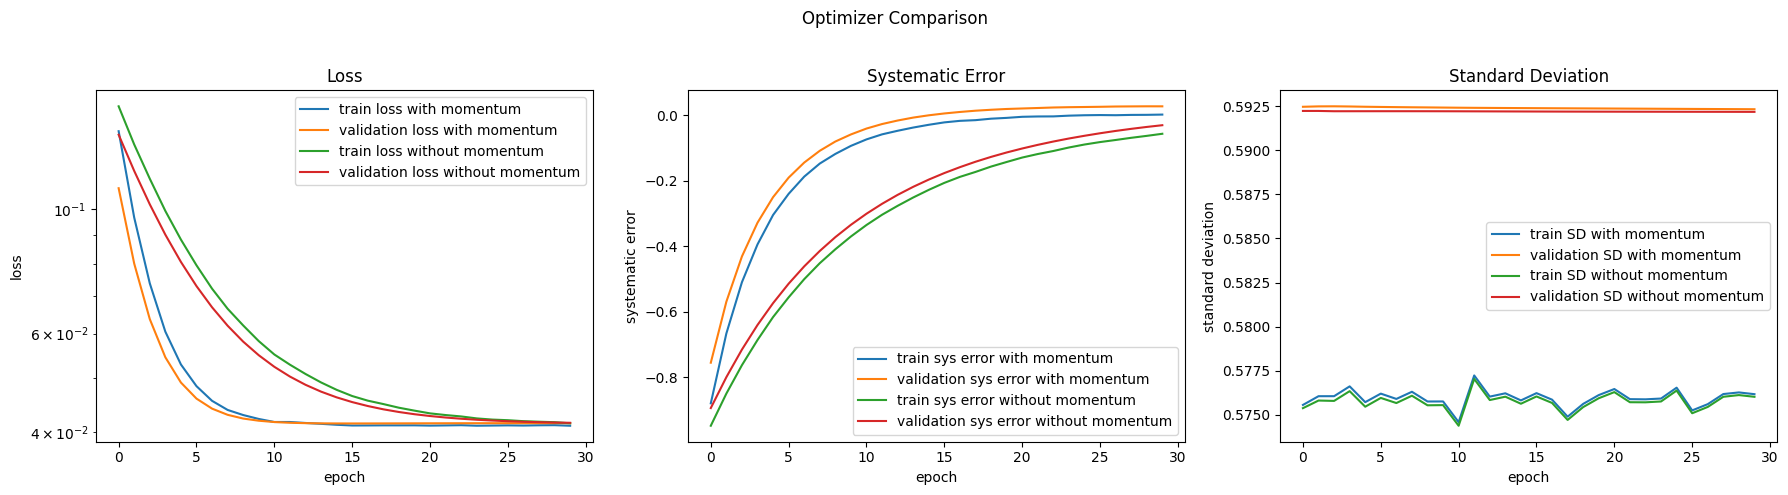

In [82]:
# Train model with momentum
plot_data_with_momentum = train_model(trainloader=trainloader, inferloader=inferloader, learning_rate=0.001, bvalues=bvalues, hidden_layers=(64,32), epochs=30, momentum=0.6, seed=seed)

# Train model without momentum
plot_data_without_momentum = train_model(trainloader=trainloader, inferloader=inferloader, learning_rate=0.001, bvalues=bvalues, hidden_layers=(64,32), epochs=30, momentum=0.0, seed=seed)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

fig.suptitle('Optimizer Comparison')

# Plot loss
axs[0].semilogy(plot_data_with_momentum['train_loss'], label='train loss with momentum')
axs[0].semilogy(plot_data_with_momentum['val_loss'], label='validation loss with momentum')
axs[0].semilogy(plot_data_without_momentum['train_loss'], label='train loss without momentum')
axs[0].semilogy(plot_data_without_momentum['val_loss'], label='validation loss without momentum')
axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('Loss')

# Plot systematic error
axs[1].plot(plot_data_with_momentum['sys_train'], label='train sys error with momentum')
axs[1].plot(plot_data_with_momentum['sys_val'], label='validation sys error with momentum')
axs[1].plot(plot_data_without_momentum['sys_train'], label='train sys error without momentum')
axs[1].plot(plot_data_without_momentum['sys_val'], label='validation sys error without momentum')
axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('systematic error')
axs[1].set_title('Systematic Error')

# Plot standard deviation
axs[2].plot(plot_data_with_momentum['SD_train'], label='train SD with momentum')
axs[2].plot(plot_data_with_momentum['SD_val'], label='validation SD with momentum')
axs[2].plot(plot_data_without_momentum['SD_train'], label='train SD without momentum')
axs[2].plot(plot_data_without_momentum['SD_val'], label='validation SD without momentum')
axs[2].legend()
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('standard deviation')
axs[2].set_title('Standard Deviation')

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


In [ ]:
# training loop from exercise 1 for comparison

import torch.nn as nn
from tqdm import tqdm

# function for stacking the layers and making the model
def make_model(n_inputs=5,n_hidden=1, hidden_width=5, n_outputs=1, activation_function='relu', output_scaling=False):
    #initialize the model object
    model = nn.Sequential()
    # add first hidden layer
    model.add_module('first_layer', nn.Linear(n_inputs, hidden_width))

    if activation_function == 'relu':
        # add ReLu layer
        model.add_module('first_ReLu', nn.ReLU())
        # fill out the model with hidden layers.
        for i in range(1, n_hidden):
            # as we loop, we add hidden layers
            model.add_module('layer_linear'+str(i), nn.Linear(hidden_width, hidden_width))
            # we also add a ReLu layer
            model.add_module('layer_ReLu'+str(i), nn.ReLU())
            
    elif activation_function == 'sigmoid':
        # add Sigmoid layer
        model.add_module('first_Sigmoid', nn.Sigmoid())
        # fill out the model with hidden layers.
        for i in range(1, n_hidden):
            # as we loop, we add hidden layers
            model.add_module('layer_linear'+str(i), nn.Linear(hidden_width, hidden_width))
            # we also add a Sigmoid layer
            model.add_module('layer_Sigmoid'+str(i), nn.Sigmoid())

    elif activation_function == 'elu':
        # add ELU layer
        model.add_module('first_ELU', nn.ELU())
        # fill out the model with hidden layers.
        for i in range(1, n_hidden):
            # as we loop, we add hidden layers
            model.add_module('layer_linear'+str(i), nn.Linear(hidden_width, hidden_width))
            # we also add a ELU layer
            model.add_module('layer_ELU'+str(i), nn.ELU())
    
    #and a final output layer
    model.add_module('last_layer',nn.Linear(hidden_width, n_outputs))
    # to ensure positive predictions, we end with a ReLu function before giving output
    model.add_module('last',nn.Sigmoid())
        
    model.apply(init_weights)
    return model

# function for initializing network weights for individual layers
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.xavier_normal_(m.weight)



def train_network_torch(name, epochs=200, learningrate=0.1, hidden_layers=2, hidden_width=5, seed=42, optimizer='SGD', bvalues=bvalues, batch_size=16, sims=1000, sim_seed=69, activation_function='relu', do_D_Dp=False, output_scaling=False, wandb_interval=10, loss_handling='total weighted', return_model=False, training_data=None, validation_data=None, test_data=None):
    """
    Trains a neural network model for medical imaging data.

    Parameters:
    -----------
    name : str
        Name of the training run, used for logging purposes.
    epochs : int, optional
        Number of epochs to train the model (default is 200).
    learningrate : float, optional
        Learning rate for the optimizer (default is 0.1).
    hidden_layers : int, optional
        Number of hidden layers in the neural network (default is 2).
    hidden_width : int, optional
        Number of neurons in each hidden layer (default is 5).
    seed : int, optional
        Random seed for reproducibility (default is 42).
    optimizer : str, optional
        Optimizer to use for training. Options are 'SGD', 'adam', or 'adagrad' (default is 'SGD').
    bvalues : list or array-like
        List of b-values used in the simulation or data generation.
    batch_size : int, optional
        Batch size for training (default is 16).
    sims : int, optional
        Number of simulations to generate training data (default is 1000).
    sim_seed : int, optional
        Random seed for data generation (default is 69).
    activation_function : str, optional
        Activation function to use in the hidden layers (default is 'relu').
    do_D_Dp : bool, optional
        Whether to predict D and Dp in addition to f (default is False).
    output_scaling : bool, optional
        Whether to scale the output of the network (default is False).
    wandb_interval : int, optional
        Interval at which to log metrics to Weights & Biases (default is 10).
    loss_handling : str, optional
        Method for handling loss when predicting D and Dp. Options are 'total weighted', 'total', 'separate', 'separate weighted', or 'separate weighted sq' (default is 'total weighted').
    return_model : bool or str, optional
        Whether to return the trained model. If 'all', returns both the plot data and the model (default is False).
    training_data : torch.utils.data.Dataset, optional
        Custom training data to use instead of generating it (default is None).
    validation_data : torch.utils.data.Dataset, optional
        Custom validation data to use instead of generating it (default is None).

    Returns:
    --------
    plot_data : dict
        Dictionary containing training and validation metrics.
    SD_test : float
        Standard deviation of the test data predictions.
    sys_test : float
        Systematic error of the test data predictions.
    test_loss : float
        Loss on the test data.
    model : torch.nn.Module, optional
        Trained model, returned if `return_model` is True or 'all'.
    """

    # get the data
    if training_data is None:
        trainloader, inferloader, testloader = sim_dat(bvalues, batch_size=batch_size, sims=sims, seed=sim_seed)
    else:
        trainloader = training_data
        inferloader = validation_data
        testloader = test_data


    # get the model
    if do_D_Dp:
        model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, hidden_width=hidden_width, n_outputs=3, activation_function=activation_function)
        D_mean, f_mean, Dp_mean = sim_dat_means(trainloader)
    else:    
        model = make_model(n_inputs=len(bvalues), n_hidden=hidden_layers, hidden_width=hidden_width, n_outputs=1, activation_function=activation_function)

    # initialize model --> we did this above, but during the exercise, you might be re-running this part of the script several times with different settings. This way we make sure you re-initiate the training and don't continue in the last model
    model.apply(init_weights)

    # initialize wandb
    wandb.init(project="AI_for_medical_imaging", job_type="training", name=name, mode="disabled")

    # set random seed for reproducibility
    torch.manual_seed(seed)

    # probe available devices
    if torch.cuda.is_available():  # GPU operation have separate seed
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False

    # Set default device. If GPU is available, the network will be trained on the GPU. Note that further down in the code, stuff will be sent ".to(device)" to make sure it is available on the GPU.
    device = torch.device('cpu')#'cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # define the loss of the network (mean square error)
    loss_module = nn.MSELoss(reduction='mean').to(device)

    # the optimizer determines how strongly to update the network's weights based on the calculated loss.
    if optimizer == 'SGD':
        optimizer = torch.optim.SGD(model.parameters(), lr=learningrate)
    elif optimizer == 'adam':
        optimizer = torch.optim.Adam(model.parameters(), lr=learningrate)
    elif optimizer == 'adagrad':
        optimizer = torch.optim.Adagrad(model.parameters(), lr=learningrate)
    else:
        raise NotImplementedError('this optimizer is not implemented yet...')

    # initialize the plot data
    plot_data = {
        "train_loss": [],
        "val_loss": [],
        "SD_train": [],
        "SD_val": [],
        "sys_train": [],
        "sys_val": [],
        "SD_val_D": [],
        "sys_val_D": [],
        "SD_train_D": [],	
        "sys_train_D": [],
        "SD_train_Dp": [],
        "sys_train_Dp": [],
        "SD_val_Dp": [],
        "sys_val_Dp": [],
        "train_loss_D": [],
        "val_loss_D": [],
        "train_loss_Dp": [],
        "val_loss_Dp": [],
        "table_train_f": [],
        "table_val_f": [],
        "table_train_D": [],
        "table_val_D": [],
        "table_train_Dp": [],
        "table_val_Dp": []
    }

    # loop over epochs
    for epoch in tqdm(range(epochs), desc="Training Progress"):
        # initiate losses and errors to 0
        train_loss_f = 0
        train_loss_D = 0
        train_loss_Dp = 0
        val_loss_f = 0
        val_loss_D = 0
        val_loss_Dp = 0
        SD_train = 0
        sys_train = 0
        if do_D_Dp:
            SD_train_D = 0
            sys_train_D = 0
            SD_train_Dp = 0
            sys_train_Dp = 0
        
        # set model to training such that forward passes are remembered (requiered for backpropogating the loss)
        model.train()

        # loop over all training data
        for x in trainloader:
            # reset the gradients to zero
            optimizer.zero_grad()
            # get data (x[0]) and put the data on the GPU if available
            batch = x[0].to(device)

            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            if do_D_Dp:
                D_ref = torch.flatten(x[1].to(device))
                Dp_ref = torch.flatten(x[3].to(device))

            # put the data through the neural network
            if do_D_Dp:
                f_pred, D_pred, Dp_pred = model.forward(batch).T
                if output_scaling: f_pred, D_pred, Dp_pred = f_pred, D_pred*3e-3+0.5e-3, Dp_pred*125e-3+5e-3
            else:
                f_pred = torch.flatten(model.forward(batch))

            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            if do_D_Dp:
                loss_D = loss_module(D_pred, D_ref)
                loss_Dp = loss_module(Dp_pred, Dp_ref)

            #add found loss to the train loss, to keep track of the loss this epoch
            train_loss_f += loss_f.item()
            if do_D_Dp:
                train_loss_D += loss_D.item()
                train_loss_Dp += loss_Dp.item()

            # propogate the loss through the network (calculate d_weights/d_loss)
            if do_D_Dp:
                if loss_handling == 'total weighted':
                    total_loss_weighted = loss_f/f_mean + loss_D/D_mean + loss_Dp/Dp_mean
                    total_loss_weighted.backward()
                elif loss_handling == 'total':
                    total_loss = loss_f + loss_D + loss_Dp
                    total_loss.backward()
                elif loss_handling == 'separate':
                    loss_f.backward(retain_graph=True)
                    loss_D.backward(retain_graph=True)
                    loss_Dp.backward()
                elif loss_handling == 'separate weighted':
                    (loss_f/f_mean).backward(retain_graph=True)
                    (loss_D/D_mean).backward(retain_graph=True)
                    (loss_Dp/Dp_mean).backward()
                elif loss_handling == 'separate weighted sq':
                    (loss_f/f_mean**2).backward(retain_graph=True)
                    (loss_D/D_mean**2).backward(retain_graph=True)
                    (loss_Dp/Dp_mean**2).backward()
                else:
                    print('loss_handling not available. Use total, total weighted, separate or separate weighted')
            else:
                loss_f.backward()

            # update all weights according to their derrivatives to the loss.
            optimizer.step()
            # calculate the standard deviation and systematic error on the trianing data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(), f_ref.cpu().detach().numpy())

            if do_D_Dp:
                SD_D, sys_D = hf.error_metrics(D_pred.cpu().detach().numpy(), D_ref.cpu().detach().numpy())
                SD_Dp, sys_Dp = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_ref.cpu().detach().numpy())

            # add the errors to ultimately calculate their mean over the training data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_train += SD**2
            sys_train += sys

            if do_D_Dp:
                SD_train_D += SD_D**2
                sys_train_D += sys_D

                SD_train_Dp += SD_Dp**2
                sys_train_Dp += sys_Dp

        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_train = np.sqrt(SD_train/trainloader.__len__())
        sys_train = sys_train/trainloader.__len__()

        if do_D_Dp:
            SD_train_D = np.sqrt(SD_train_D/trainloader.__len__())
            sys_train_D = sys_train_D/trainloader.__len__()

            SD_train_Dp = np.sqrt(SD_train_Dp/trainloader.__len__())
            sys_train_Dp = sys_train_Dp/trainloader.__len__()


        #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
        example_data=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
        if do_D_Dp:
            example_data_D=[[x,y] for (x,y) in zip(D_ref.cpu().detach().numpy(),D_pred.cpu().detach().numpy())]
            example_data_Dp=[[x,y] for (x,y) in zip(Dp_ref.cpu().detach().numpy(),Dp_pred.cpu().detach().numpy())]
        
        # after training, set model to evaluation mode
        model.eval()
        
        if not return_model or return_model == 'all':

            ######################your code here for validation loss#########################

            # initialize error_metrics
            SD_val = 0
            sys_val = 0


            if do_D_Dp:
                SD_val_D = 0
                sys_val_D = 0
                SD_val_Dp = 0
                sys_val_Dp = 0

            for x in inferloader:
                # get data (x[0]) and put the data on the GPU if available
                batch = x[0].to(device)
                # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
                f_ref = torch.flatten(x[2].to(device))

                if do_D_Dp:
                    D_ref = torch.flatten(x[1].to(device))
                    Dp_ref = torch.flatten(x[3].to(device))

                # put the data through the neural network
                if do_D_Dp:
                    f_pred, D_pred, Dp_pred = model.forward(batch).T
                    if output_scaling: f_pred, D_pred, Dp_pred = f_pred, D_pred*3e-3+0.5e-3, Dp_pred*125e-3+5e-3
                else:
                    f_pred = torch.flatten(model.forward(batch))

                # calculate loss (compare predicted f to the ground trueth)
                loss_f = loss_module(f_pred, f_ref)

                if do_D_Dp:
                    loss_D = loss_module(D_pred, D_ref)
                    loss_Dp = loss_module(Dp_pred, Dp_ref)

                #add found loss to the validation loss, to keep track of the loss this epoch
                val_loss_f += loss_f.item()

                if do_D_Dp:
                    val_loss_D += loss_D.item()
                    val_loss_Dp += loss_Dp.item()

                # calculate the standard deviation and systematic error on the validation data
                SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())

                if do_D_Dp:
                    SD_D, sys_D = hf.error_metrics(D_pred.cpu().detach().numpy(), D_ref.cpu().detach().numpy())
                    SD_Dp, sys_Dp = hf.error_metrics(Dp_pred.cpu().detach().numpy(), Dp_ref.cpu().detach().numpy())

                # add the errors to ultimately calculate their mean over the validation data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
                SD_val += SD**2
                sys_val += sys

                if do_D_Dp:
                    SD_val_D += SD_D**2
                    sys_val_D += sys_D

                    SD_val_Dp += SD_Dp**2
                    sys_val_Dp += sys_Dp


            #make b-value data pairs: Note these currently contain the f_ref and f_pred from the trianing data. You may want to swap to validation data once implemented
            example_data_val=[[x,y] for (x,y) in zip(f_ref.cpu().detach().numpy(),f_pred.cpu().detach().numpy())]
            
            if do_D_Dp:
                example_data_val_D=[[x,y] for (x,y) in zip(D_ref.cpu().detach().numpy(),D_pred.cpu().detach().numpy())]
                example_data_val_Dp=[[x,y] for (x,y) in zip(Dp_ref.cpu().detach().numpy(),Dp_pred.cpu().detach().numpy())]
            

            # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
            SD_val = np.sqrt(SD_val/inferloader.__len__())
            sys_val = sys_val/inferloader.__len__()

            if do_D_Dp:
                SD_val_D = np.sqrt(SD_val_D/inferloader.__len__())
                sys_val_D = sys_val_D/inferloader.__len__()

                SD_val_Dp = np.sqrt(SD_val_Dp/inferloader.__len__())
                sys_val_Dp = sys_val_Dp/inferloader.__len__()
            
            # put it in a table
            table = wandb.Table(data=example_data, columns=["f_ref", "f_pred"])
            if do_D_Dp:
                table_D = wandb.Table(data=example_data_D, columns=["D_ref", "D_pred"])
                table_Dp = wandb.Table(data=example_data_Dp, columns=["Dp_ref", "Dp_pred"])

            # tell wandb to plot the table for the validation data
            table_val = wandb.Table(data=example_data_val, columns=["f_ref", "f_pred"])
            if do_D_Dp:
                table_D_val = wandb.Table(data=example_data_val_D, columns=["D_ref", "D_pred"])
                table_Dp_val = wandb.Table(data=example_data_val_Dp, columns=["Dp_ref", "Dp_pred"])

            #tell wandb to plot the table
            # note that some parameters are being logged which you still need to define in the validation loop!
            if epoch % wandb_interval == 0:
                wandb.log({"loss/train": train_loss_f/trainloader.__len__(),
                "loss/val": val_loss_f/inferloader.__len__(),
                "error/random error": SD_train,
                "error/systematic error": sys_train,
                "Training Data (Epoch " + str(epoch) + ")": wandb.plot.scatter(table, "f_ref", "f_pred", title=f'Training Data f (Epoch {epoch})'),
                "Validation Data (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_val, "f_ref", "f_pred", title=f'Validation Data f (Epoch {epoch})')})
                if do_D_Dp:
                    wandb.log({
                        "loss/train_D": train_loss_D/trainloader.__len__(),
                        "loss/val_D": val_loss_D/inferloader.__len__(),
                        "error/random error_D": SD_train_D,
                        "error/systematic error_D": sys_train_D,
                        "Training Data D (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_D, "D_ref", "D_pred", title=f'Training Data D (Epoch {epoch})')
                        })
                    wandb.log({"loss/train_Dp": train_loss_Dp/trainloader.__len__(),
                        "loss/val_Dp": val_loss_Dp/inferloader.__len__(),
                        "error/random error_Dp": SD_train_Dp,
                        "error/systematic error_Dp": sys_train_Dp,
                        "Training Data Dp (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_Dp, "Dp_ref", "Dp_pred", title=f'Training Data Dp (Epoch {epoch})')})
                    
                    wandb.log({
                        "Validation Data D (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_D_val, "D_ref", "D_pred", title=f'Validation Data D (Epoch {epoch})'),
                        "Validation Data Dp (Epoch " + str(epoch) + ")": wandb.plot.scatter(table_Dp_val, "Dp_ref", "Dp_pred", title=f'Validation Data Dp (Epoch {epoch})')})

            # add the data to the plot_data dictionary
            plot_data["train_loss"].append(train_loss_f/trainloader.__len__())
            plot_data["val_loss"].append(val_loss_f/inferloader.__len__())
            plot_data["SD_train"].append(SD_train)
            plot_data["SD_val"].append(SD_val)  
            plot_data["sys_train"].append(sys_train)
            plot_data["sys_val"].append(sys_val)
            plot_data["table_train_f"].append(example_data)
            plot_data["table_val_f"].append(example_data_val)
            if do_D_Dp:
                plot_data["SD_train_D"].append(SD_train_D)
                plot_data["sys_train_D"].append(sys_train_D)
                plot_data["SD_train_Dp"].append(SD_train_Dp)
                plot_data["sys_train_Dp"].append(sys_train_Dp)
                plot_data["SD_val_D"].append(SD_val_D)
                plot_data["sys_val_D"].append(sys_val_D)
                plot_data["SD_val_Dp"].append(SD_val_Dp)
                plot_data["sys_val_Dp"].append(sys_val_Dp)
                plot_data["train_loss_D"].append(train_loss_D/trainloader.__len__())
                plot_data["val_loss_D"].append(val_loss_D/inferloader.__len__())
                plot_data["train_loss_Dp"].append(train_loss_Dp/trainloader.__len__())
                plot_data["val_loss_Dp"].append(val_loss_Dp/inferloader.__len__())
                plot_data["table_train_D"].append(example_data_D)
                plot_data["table_val_D"].append(example_data_val_D)
                plot_data["table_train_Dp"].append(example_data_Dp)
                plot_data["table_val_Dp"].append(example_data_val_Dp)


            ## print output in terminal. Only useful for debugging when WandB does not work
            #print('epoch = ' + str(epoch) + ' train loss =' + str(train_loss_f/trainloader.__len__()) +' val loss =' + str(val_loss_f/inferloader.__len__()) + 'the systematic error is ' + str(sys_val) + ' and the random error is ' + str(SD_val))

    wandb.finish()

    if not return_model or return_model == 'all':
        ######################your code here for testing loss#########################

        # initialize error_metrics
        SD_test=0
        sys_test=0
        test_loss_f=0
        for x in testloader:
            # get data (x[0]) and put the data on the GPU if available
            batch=x[0].to(device)
            # get the reference f (x[2]) --> note x[1] and x[3] are D and Dp respectively
            f_ref = torch.flatten(x[2].to(device))
            # put the data through the neural network
            if do_D_Dp:
                f_pred, D_pred, Dp_pred = model.forward(batch).T
            else:
                f_pred = torch.flatten(model.forward(batch))
            # calculate loss (compare predicted f to the ground trueth)
            loss_f = loss_module(f_pred, f_ref)
            #add found loss to the validation loss, to keep track of the loss this epoch
            test_loss_f += loss_f.item()
            # calculate the standard deviation and systematic error on the validation data
            SD, sys = hf.error_metrics(f_pred.cpu().detach().numpy(),f_ref.cpu().detach().numpy())
            # add the errors to ultimately calculate their mean over the validation data. calculating mean SDs goes via the Root Mean Squares. So add SDs squared
            SD_test += SD**2
            sys_test += sys

        # now divide by the total amount of training data to calculate the mean (sys error) and square of mean (SD).
        SD_test = np.sqrt(SD_test/testloader.__len__())
        sys_test = sys_test/testloader.__len__()
        test_loss = test_loss_f/testloader.__len__()

        return plot_data, SD_test, sys_test, test_loss
    elif return_model == 'all':
        return plot_data, model
    else:
        return model

Training Progress: 100%|██████████| 30/30 [00:03<00:00,  8.05it/s]


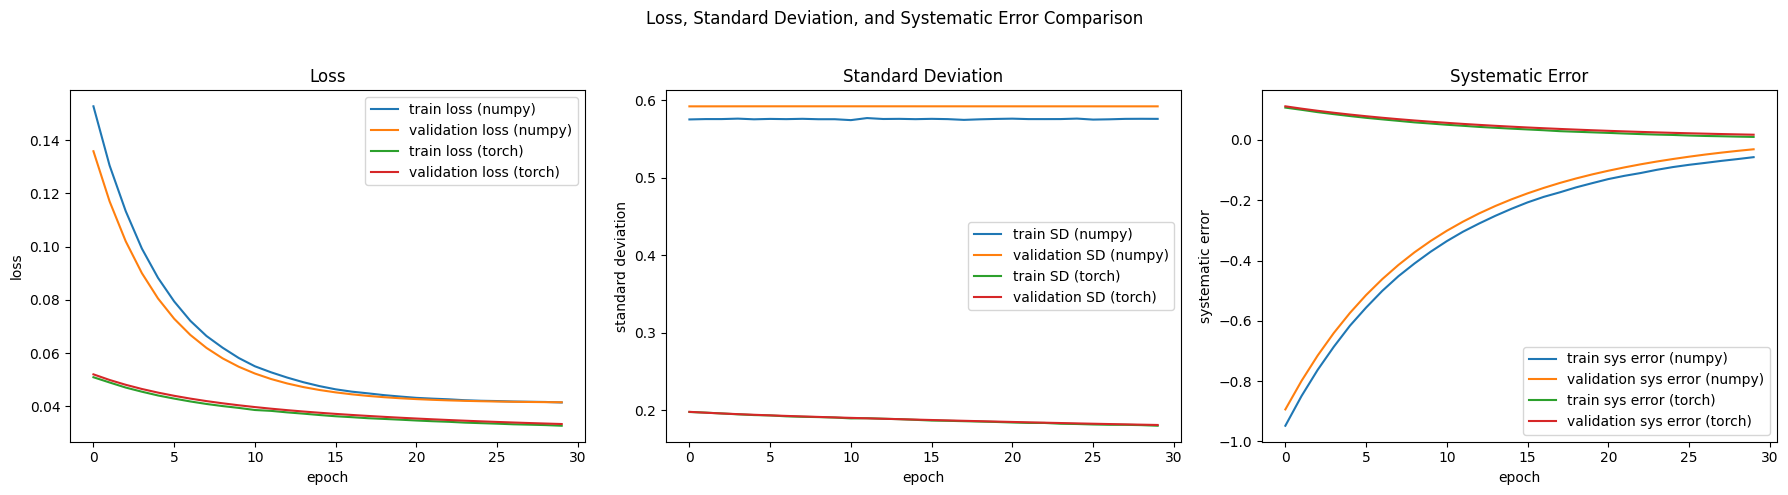

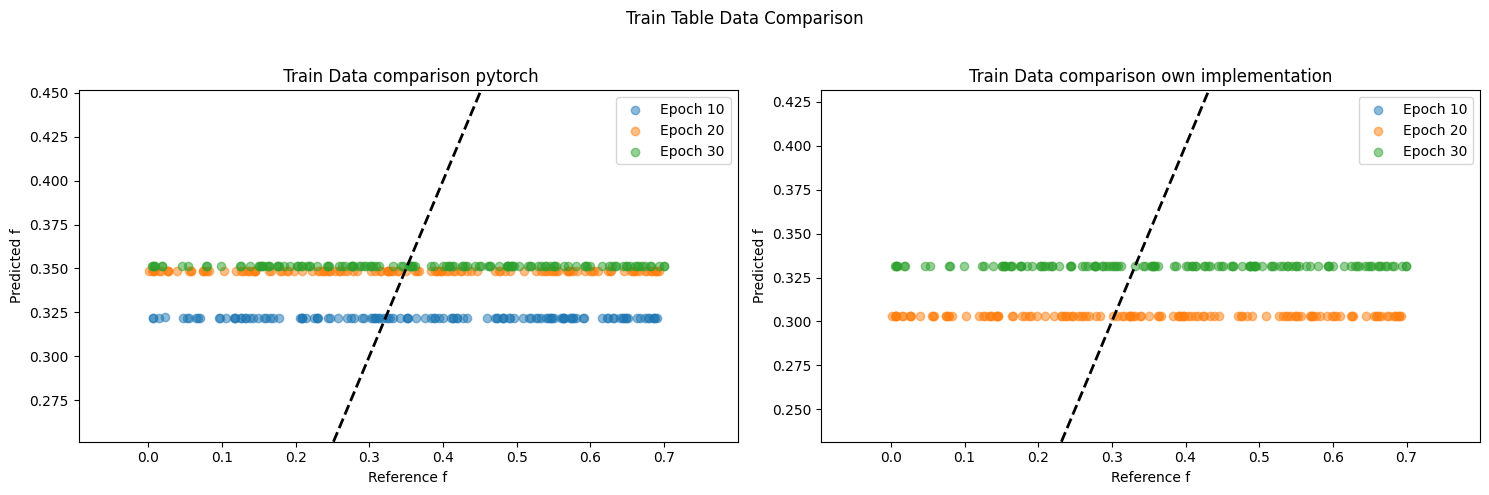

In [120]:
learning_rate = 0.001
epochs = 30
hidden_width = 64
hidden_layers = 2

# Train model without momentum
plot_data_without_momentum = train_model(trainloader=trainloader, inferloader=inferloader, learning_rate=learning_rate, bvalues=bvalues, hidden_layers=(hidden_width,hidden_width), epochs=epochs, momentum=0.0, seed=seed)

plot_data_without_momentum_torch = train_network_torch(name = "np vs torch", training_data=trainloader, validation_data=inferloader, test_data=testloader,  learningrate=learning_rate, bvalues=bvalues, hidden_layers=hidden_layers, hidden_width=hidden_width, epochs=epochs, seed=seed)

fig, axs = plt.subplots(1, 3, figsize=(18, 5))

fig.suptitle('Loss, Standard Deviation, and Systematic Error Comparison')

# Plot loss for the numpy model without momentum
axs[0].plot(plot_data_without_momentum['train_loss'], label='train loss (numpy)')
axs[0].plot(plot_data_without_momentum['val_loss'], label='validation loss (numpy)')

# Plot loss for the torch model without momentum
axs[0].plot(plot_data_without_momentum_torch[0]['train_loss'], label='train loss (torch)')
axs[0].plot(plot_data_without_momentum_torch[0]['val_loss'], label='validation loss (torch)')

axs[0].legend()
axs[0].set_xlabel('epoch')
axs[0].set_ylabel('loss')
axs[0].set_title('Loss')

# Plot standard deviation for the numpy model without momentum
axs[1].plot(plot_data_without_momentum['SD_train'], label='train SD (numpy)')
axs[1].plot(plot_data_without_momentum['SD_val'], label='validation SD (numpy)')

# Plot standard deviation for the torch model without momentum
axs[1].plot(plot_data_without_momentum_torch[0]['SD_train'], label='train SD (torch)')
axs[1].plot(plot_data_without_momentum_torch[0]['SD_val'], label='validation SD (torch)')

axs[1].legend()
axs[1].set_xlabel('epoch')
axs[1].set_ylabel('standard deviation')
axs[1].set_title('Standard Deviation')

# Plot systematic error for the numpy model without momentum
axs[2].plot(plot_data_without_momentum['sys_train'], label='train sys error (numpy)')
axs[2].plot(plot_data_without_momentum['sys_val'], label='validation sys error (numpy)')

# Plot systematic error for the torch model without momentum
axs[2].plot(plot_data_without_momentum_torch[0]['sys_train'], label='train sys error (torch)')
axs[2].plot(plot_data_without_momentum_torch[0]['sys_val'], label='validation sys error (torch)')

axs[2].legend()
axs[2].set_xlabel('epoch')
axs[2].set_ylabel('systematic error')
axs[2].set_title('Systematic Error')

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Plot train table data for the model with and without momentum
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Train Table Data Comparison')

# Train data with momentum
axs[0].set_title(' Train Data comparison pytorch')
for epoch, data in enumerate(plot_data_with_momentum['table_train']):
    if (epoch+1) % 10 == 0:
        f_ref, f_pred = zip(*data)
        axs[0].scatter(f_ref, f_pred, alpha=0.5, label=f'Epoch {epoch+1}')
axs[0].plot([0, 1], [0, 1], 'k--', lw=2)
axs[0].set_xlabel('Reference f')
axs[0].set_ylabel('Predicted f')
axs[0].set_xlim([min(f_ref) - 0.1, max(f_ref) + 0.1])
axs[0].set_ylim([min(f_pred) - 0.1, max(f_pred) + 0.1])
axs[0].legend()

# Train data without momentum
axs[1].set_title('Train Data comparison own implementation')
for epoch, data in enumerate(plot_data_without_momentum['table_train']):
    if (epoch+1) % 10 == 0:
        f_ref, f_pred = zip(*data)
        axs[1].scatter(f_ref, f_pred, alpha=0.5, label=f'Epoch {epoch+1}')
axs[1].plot([0, 1], [0, 1], 'k--', lw=2)
axs[1].set_xlabel('Reference f')
axs[1].set_ylabel('Predicted f')
axs[1].set_xlim([min(f_ref) - 0.1, max(f_ref) + 0.1])
axs[1].set_ylim([min(f_pred) - 0.1, max(f_pred) + 0.1])
axs[1].legend()

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [ ]:
# Train model without momentum
plot_data_without_momentum = train_model(trainloader=trainloader, inferloader=inferloader, learning_rate=0.001, bvalues=bvalues, hidden_layers=(64,64), epochs=30, momentum=0.0, seed=seed)

plot_data_without_momentum_torch = train_network_torch(name = "np vs torch", training_data=trainloader, validation_data=inferloader, test_data=testloader,  learningrate=0.001, bvalues=bvalues, hidden_layers=2, hidden_width=64, epochs=30, seed=seed)

fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle('Loss Comparison')

# Plot loss for the numpy model without momentum
ax.plot(plot_data_without_momentum['train_loss'], label='train loss (numpy)')
ax.plot(plot_data_without_momentum['val_loss'], label='validation loss (numpy)')

# Plot loss for the torch model without momentum
ax.plot(plot_data_without_momentum_torch[0]['train_loss'], label='train loss (torch)')
ax.plot(plot_data_without_momentum_torch[0]['val_loss'], label='validation loss (torch)')

ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('loss')

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

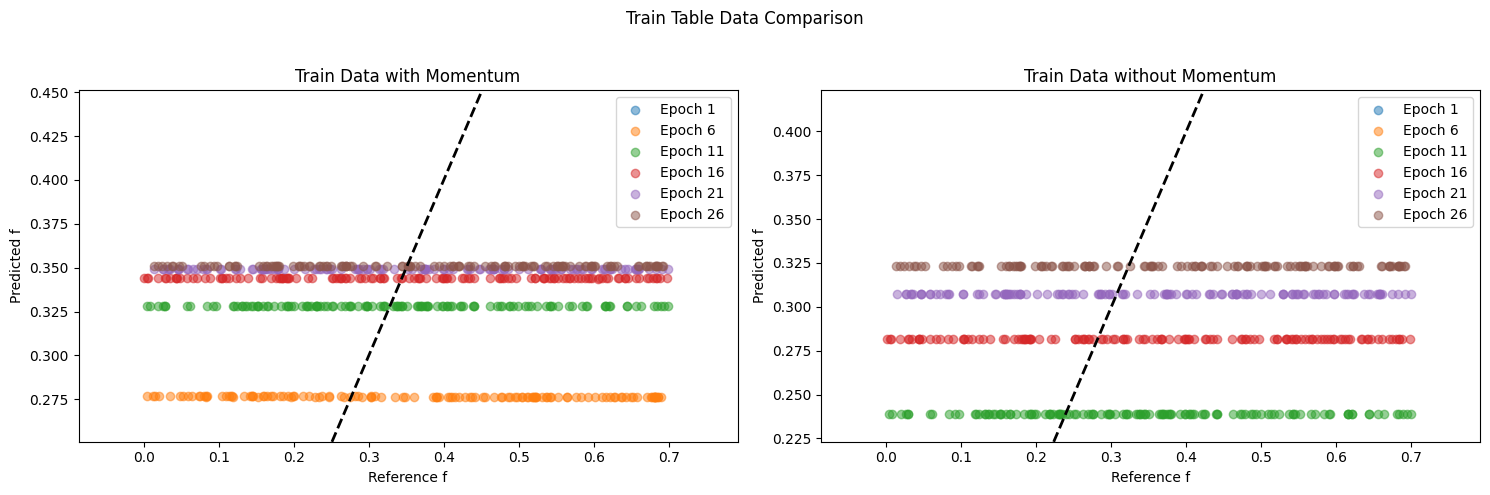

In [84]:
# Plot train table data for the model with and without momentum
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle('Train Table Data Comparison')

# Train data with momentum
axs[0].set_title('Train Data with Momentum')
for epoch, data in enumerate(plot_data_with_momentum['table_train']):
    if epoch % 5 == 0:
        f_ref, f_pred = zip(*data)
        axs[0].scatter(f_ref, f_pred, alpha=0.5, label=f'Epoch {epoch+1}')
axs[0].plot([0, 1], [0, 1], 'k--', lw=2)
axs[0].set_xlabel('Reference f')
axs[0].set_ylabel('Predicted f')
axs[0].set_xlim([min(f_ref) - 0.1, max(f_ref) + 0.1])
axs[0].set_ylim([min(f_pred) - 0.1, max(f_pred) + 0.1])
axs[0].legend()

# Train data without momentum
axs[1].set_title('Train Data without Momentum')
for epoch, data in enumerate(plot_data_without_momentum['table_train']):
    if epoch % 5 == 0:
        f_ref, f_pred = zip(*data)
        axs[1].scatter(f_ref, f_pred, alpha=0.5, label=f'Epoch {epoch+1}')
axs[1].plot([0, 1], [0, 1], 'k--', lw=2)
axs[1].set_xlabel('Reference f')
axs[1].set_ylabel('Predicted f')
axs[1].set_xlim([min(f_ref) - 0.1, max(f_ref) + 0.1])
axs[1].set_ylim([min(f_pred) - 0.1, max(f_pred) + 0.1])
axs[1].legend()

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


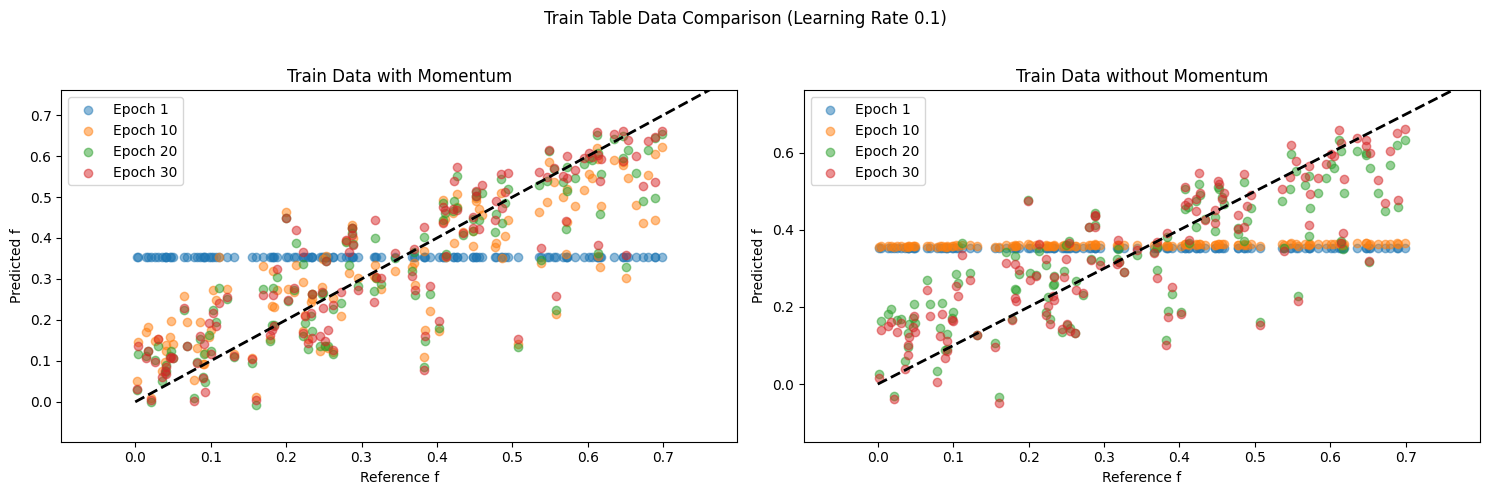

In [75]:
learning_rate = 0.1

# Train model with momentum
plot_data_with_momentum_2 = train_model(trainloader=trainloader, inferloader=inferloader, learning_rate=learning_rate, bvalues=bvalues, hidden_layers=(64,32), epochs=30, momentum=0.6, seed=seed)

# Train model without momentum
plot_data_without_momentum_2 = train_model(trainloader=trainloader, inferloader=inferloader, learning_rate=learning_rate, bvalues=bvalues, hidden_layers=(64,32), epochs=30, momentum=0.0, seed=seed)

# Plot train table data for the model with and without momentum
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

fig.suptitle(f'Train Table Data Comparison (Learning Rate {learning_rate})')

# Train data with momentum
axs[0].set_title('Train Data with Momentum')
for epoch, data in enumerate(plot_data_with_momentum_2['table_val']):
    if (epoch+1) % 10 == 0 or epoch == 0:
        f_ref, f_pred = zip(*data)
        axs[0].scatter(f_ref, f_pred, alpha=0.5, label=f'Epoch {epoch+1}')
axs[0].plot([0, 1], [0, 1], 'k--', lw=2)
axs[0].set_xlabel('Reference f')
axs[0].set_ylabel('Predicted f')
axs[0].legend()
axs[0].set_xlim([min(f_ref) - 0.1, max(f_ref) + 0.1])
axs[0].set_ylim([min(f_pred) - 0.1, max(f_pred) + 0.1])

# Train data without momentum
axs[1].set_title('Train Data without Momentum')
for epoch, data in enumerate(plot_data_without_momentum_2['table_val']):
    if (epoch+1) % 10 == 0 or epoch == 0:
        f_ref, f_pred = zip(*data)
        axs[1].scatter(f_ref, f_pred, alpha=0.5, label=f'Epoch {epoch+1}')
axs[1].plot([0, 1], [0, 1], 'k--', lw=2)
axs[1].set_xlabel('Reference f')
axs[1].set_ylabel('Predicted f')
axs[1].legend()
axs[1].set_xlim([min(f_ref) - 0.1, max(f_ref) + 0.1])
axs[1].set_ylim([min(f_pred) - 0.1, max(f_pred) + 0.1])

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()


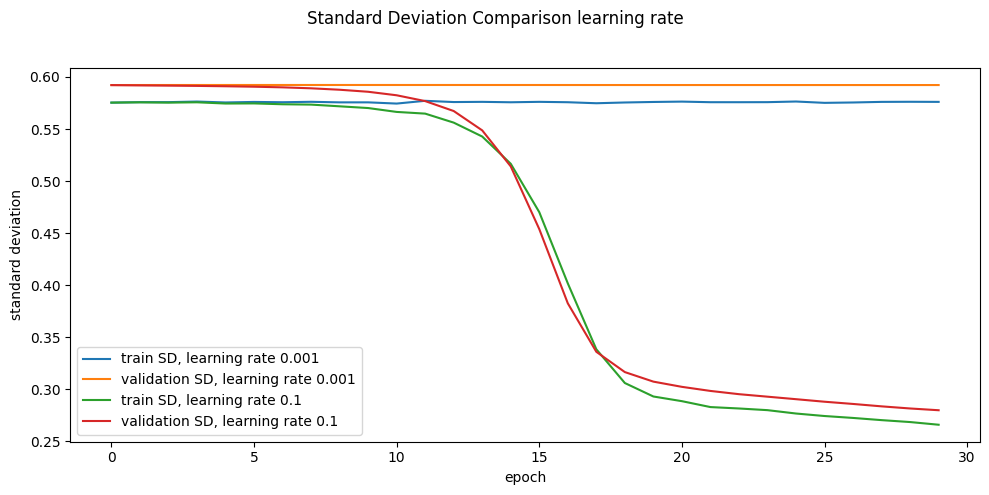

In [79]:
fig, ax = plt.subplots(figsize=(10, 5))

fig.suptitle('Standard Deviation Comparison learning rate')

# Plot standard deviation for the last two runs
ax.plot(plot_data_without_momentum['SD_train'], label='train SD, learning rate 0.001')
ax.plot(plot_data_without_momentum['SD_val'], label='validation SD, learning rate 0.001')
ax.plot(plot_data_without_momentum_2['SD_train'], label='train SD, learning rate 0.1')
ax.plot(plot_data_without_momentum_2['SD_val'], label='validation SD, learning rate 0.1')

ax.legend()
ax.set_xlabel('epoch')
ax.set_ylabel('standard deviation')

fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()